In [1]:
# library for mathematical functions and data preprocessing such as table, etc
import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import skew

# Library for visualizing data
import matplotlib.pyplot as plt
import seaborn as sns

# Library for machine learning functions/algorithms
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score,  precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline


In [2]:
# data itself
url = 'lending_club_loan_two.csv'
# description of each column
url_info = 'lending_club_info.csv'
df_before = pd.read_csv(url)
df_info = pd.read_csv(url_info)
df_before.head()

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,...,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies,address
0,10000.0,36 months,11.44,329.48,B,B4,Marketing,10+ years,RENT,117000.0,...,16.0,0.0,36369.0,41.8,25.0,w,INDIVIDUAL,0.0,0.0,"0174 Michelle Gateway\nMendozaberg, OK 22690"
1,8000.0,36 months,11.99,265.68,B,B5,Credit analyst,4 years,MORTGAGE,65000.0,...,17.0,0.0,20131.0,53.3,27.0,f,INDIVIDUAL,3.0,0.0,"1076 Carney Fort Apt. 347\nLoganmouth, SD 05113"
2,15600.0,36 months,10.49,506.97,B,B3,Statistician,< 1 year,RENT,43057.0,...,13.0,0.0,11987.0,92.2,26.0,f,INDIVIDUAL,0.0,0.0,"87025 Mark Dale Apt. 269\nNew Sabrina, WV 05113"
3,7200.0,36 months,6.49,220.65,A,A2,Client Advocate,6 years,RENT,54000.0,...,6.0,0.0,5472.0,21.5,13.0,f,INDIVIDUAL,0.0,0.0,"823 Reid Ford\nDelacruzside, MA 00813"
4,24375.0,60 months,17.27,609.33,C,C5,Destiny Management Inc.,9 years,MORTGAGE,55000.0,...,13.0,0.0,24584.0,69.8,43.0,f,INDIVIDUAL,1.0,0.0,"679 Luna Roads\nGreggshire, VA 11650"


In [3]:
# Reason:
# These features lack direct relevance to a person's ability to secure a loan. 
# grade and subgrade, summarizes the loan status, can be substituted with existing data like interest rates and annual income

columns_to_drop = ['emp_title', 'address', 'issue_d', 'title', 'earliest_cr_line', 'initial_list_status', 'grade', 'sub_grade', 'purpose']
df_before = df_before.drop(columns=columns_to_drop)

In [4]:
df_before.isna().sum()

loan_amnt                   0
term                        0
int_rate                    0
installment                 0
emp_length              18301
home_ownership              0
annual_inc                  0
verification_status         0
loan_status                 0
dti                         0
open_acc                    0
pub_rec                     0
revol_bal                   0
revol_util                276
total_acc                   0
application_type            0
mort_acc                37795
pub_rec_bankruptcies      535
dtype: int64

In [5]:
# label encoder and fit_transform is a function that changes/remap string into number based on alphabetical order
le = LabelEncoder() 
df_before['term'] = le.fit_transform(df_before['term'])
# 36 months = 0,  60 months = 1

df_before['emp_length'] = le.fit_transform(df_before['emp_length'])
# '1 year' = 0, '10+ years' = 1, '2 years' = 2, '3 years' = 3, '4 years' = 4, '5 years' = 5,   
# '6 years' = 6, '7 years' = 7, '8 years' = 8,  '9 years' = 9, '< 1 year' = 10

df_before['home_ownership'] = le.fit_transform(df_before['home_ownership'])
# 'ANY' = 0, 'MORTGAGE' = 1, 'NONE' = 2, 'OTHER' = 3, 'OWN' = 4, 'RENT' = 5

df_before['verification_status'] = le.fit_transform(df_before['verification_status'])
# 'Not Verified' = 0, 'Source Verified' = 1, 'Verified' = 2

df_before['loan_status'] = le.fit_transform(df_before['loan_status'])
# 'Charged Off' = 0, 'Fully Paid' = 1 

df_before['application_type'] = le.fit_transform(df_before['application_type'])
# 'DIRECT_PAY' = 0, 'INDIVIDUAL' = 1, 'JOINT' = 2

In [6]:
df_before['emp_length'].fillna(df_before['emp_length'].median(), inplace=True)
df_before['pub_rec_bankruptcies'].fillna(df_before['pub_rec_bankruptcies'].median(), inplace=True)
df_before['mort_acc'].fillna(df_before['mort_acc'].median(), inplace=True)
df_before['revol_util'].fillna(df_before['revol_util'].mean(), inplace=True)

In [7]:
df_before.isna().sum()

loan_amnt               0
term                    0
int_rate                0
installment             0
emp_length              0
home_ownership          0
annual_inc              0
verification_status     0
loan_status             0
dti                     0
open_acc                0
pub_rec                 0
revol_bal               0
revol_util              0
total_acc               0
application_type        0
mort_acc                0
pub_rec_bankruptcies    0
dtype: int64

### Outlier Treatment (Outlier doesnt affect accuracy much so i decided to treat it Research more later)

In [8]:
z_score_vars = ['loan_amnt', 'int_rate', 'installment', 'annual_inc', 'dti', 'open_acc', 'pub_rec', 'revol_bal', 'total_acc']

no_outlier = df_before.copy()

# Function to detect and remove outliers using IQR method
def remove_outliers_iqr(data, col):
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1

    lower_limit = Q1 - 1.5 * IQR
    upper_limit = Q3 + 1.5 * IQR

    # Count outliers before clipping
    outlier_count = ((data[col] < lower_limit) | (data[col] > upper_limit)).sum()
    total_count = len(data[col])
    outlier_percentage = outlier_count / total_count * 100

    # Print outlier information for the column
    print(f"- {col}: {outlier_count} outliers ({outlier_percentage:.2f}%)")

    # Remove outliers
    data = data[(data[col] >= lower_limit) & (data[col] <= upper_limit)]
    return data, {'count': outlier_count, 'percentage': outlier_percentage}

# Create a copy of the original dataframe
no_outlier_iqr = df_before.copy()

# Store outlier counts and percentages for each column
outlier_info_iqr = {}

for col in z_score_vars:
    # Remove outliers using IQR method
    no_outlier_iqr, info = remove_outliers_iqr(no_outlier_iqr, col)
    outlier_info_iqr[col] = info

# Print outlier information for each column using IQR method
print("\nOutlier information using IQR method:")
for col, info in outlier_info_iqr.items():
    print(f"- {col}: {info['count']} outliers ({info['percentage']:.2f}%)")


- loan_amnt: 191 outliers (0.05%)
- int_rate: 3774 outliers (0.95%)
- installment: 10896 outliers (2.78%)
- annual_inc: 15209 outliers (3.99%)
- dti: 232 outliers (0.06%)
- open_acc: 8720 outliers (2.38%)
- pub_rec: 53324 outliers (14.94%)
- revol_bal: 13829 outliers (4.55%)
- total_acc: 5096 outliers (1.76%)

Outlier information using IQR method:
- loan_amnt: 191 outliers (0.05%)
- int_rate: 3774 outliers (0.95%)
- installment: 10896 outliers (2.78%)
- annual_inc: 15209 outliers (3.99%)
- dti: 232 outliers (0.06%)
- open_acc: 8720 outliers (2.38%)
- pub_rec: 53324 outliers (14.94%)
- revol_bal: 13829 outliers (4.55%)
- total_acc: 5096 outliers (1.76%)


## Random Forest Classification (Model Generation)

In [9]:
#  SPLIT
target_column = 'loan_status'
feature_columns = no_outlier_iqr.columns[no_outlier_iqr.columns != target_column]

X = no_outlier_iqr[feature_columns]
y = no_outlier_iqr[target_column]

In [10]:
# use the pareto priuncple 
# split 80 train 10 validate 10 test

# Perform stratified sampling
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

X_validation, X_test, y_validation, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=0)

# Now X_train, X_test, y_train, y_test can be used for training and testing


# Check the number of data points in each set
print("Number of data points in training set:", X_train.shape[0])
print("Number of data points in validation set:", X_validation.shape[0])
print("Number of data points in test set:", X_test.shape[0])


Number of data points in training set: 227807
Number of data points in validation set: 28476
Number of data points in test set: 28476


In [11]:
rus = RandomUnderSampler(sampling_strategy=0.5, random_state=0)
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)

from imblearn.over_sampling import RandomOverSampler
# Instantiate the RandomOverSampler
ros = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train_rus, y_train_rus)



In [12]:
data = y_train.value_counts()
print(data)

loan_status
1    183709
0     44098
Name: count, dtype: int64


In [13]:
data_counts = y_train_resampled.value_counts()
print(data_counts)

loan_status
0    88196
1    88196
Name: count, dtype: int64


In [15]:
from sklearn.neural_network import MLPClassifier

# Initialize a multi-layer perceptron classifier
mlp = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=500, activation='relu', solver='adam')

# Train the model on the training data
mlp.fit(X_train_resampled, y_train_resampled)

# Make predictions on the testing set
y_pred = mlp.predict(X_test)

# Calculate accuracy
accuracy = mlp.score(X_test, y_test)
print("Accuracy:", accuracy)

Accuracy: 0.7524230931310577


In [20]:
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix\n", cm)

Confusion Matrix
 [[ 2193  3351]
 [ 3699 19233]]


In [21]:
target_names = ['Charged Off', 'Fully Paid']
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

 Charged Off       0.37      0.40      0.38      5544
  Fully Paid       0.85      0.84      0.85     22932

    accuracy                           0.75     28476
   macro avg       0.61      0.62      0.61     28476
weighted avg       0.76      0.75      0.76     28476



In [22]:
TN, FP, FN, TP = cm.ravel()

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

precision = precision_score(y_test, y_pred)
print("Precision:", precision)

recall = recall_score(y_test, y_pred)
print("Recall:", recall)

specificity = TN / (TN + FP)
print("Specificity:", specificity)

f1 = f1_score(y_test, y_pred)
print("F1 Score:", f1)

Accuracy: 0.7524230931310577
Precision: 0.8516206163655685
Recall: 0.8386970172684458
Specificity: 0.39556277056277056
F1 Score: 0.8451094120748747


AUC Score: 0.6933000546946125


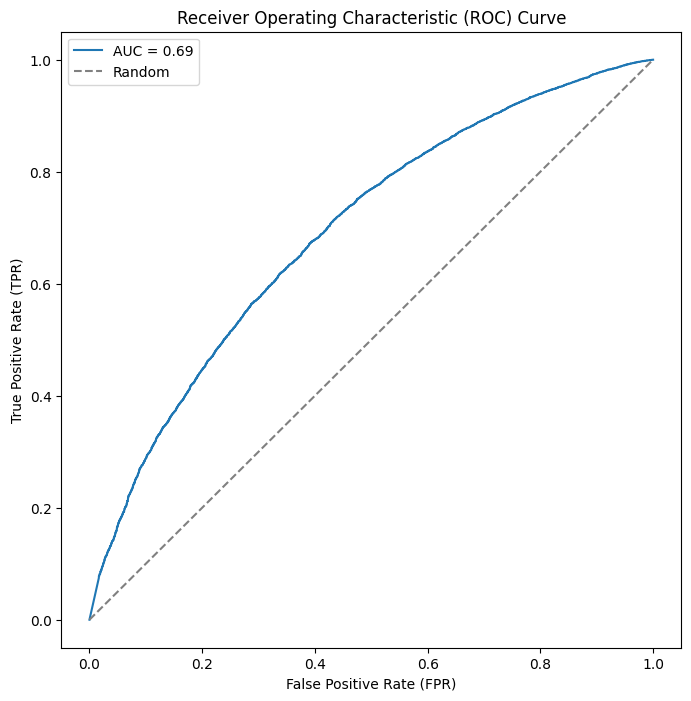

In [23]:
# Assuming you have the predicted probabilities for the positive class
y_prob_test = mlp.predict_proba(X_test)[:, 1]

# Calculate AUC score
auc_score = roc_auc_score(y_test, y_prob_test)
print("AUC Score:", auc_score)

# Plot the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob_test)

plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, label=f'AUC = {auc_score:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.legend()
plt.show()

# is 69 auc score good what does it mean, what can i do to increase it?